# Train xView2 with FastAIv2

The currenty first place model of xView2 uses a total of eight models (one each of 34, 50, 92, and 154 for both cls and loc). The goal is to create a single model for each of loc and cls, potentially a single model for both. Additionally, we would like to use an architecture that can support multiple sizes to support better accuracy on accelerated machines or reduced accuracy capable of running on an edge device.

In [1]:
from fastai.vision.all import *
from fastai.optimizer import ranger
from pathlib import Path
from PIL import Image

/home/epound/miniconda3/envs/fastai/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/epound/miniconda3/envs/fastai/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
TRAIN_PATH = Path("/home/epound/temp/train")
DEVICE = "cuda:1"

In [3]:
get_image_files(TRAIN_PATH/"images")

(#5598) [Path('/home/epound/temp/train/images/socal-fire_00001263_post_disaster.png'),Path('/home/epound/temp/train/images/socal-fire_00000793_pre_disaster.png'),Path('/home/epound/temp/train/images/socal-fire_00001118_post_disaster.png'),Path('/home/epound/temp/train/images/palu-tsunami_00000191_post_disaster.png'),Path('/home/epound/temp/train/images/hurricane-michael_00000292_pre_disaster.png'),Path('/home/epound/temp/train/images/palu-tsunami_00000148_pre_disaster.png'),Path('/home/epound/temp/train/images/socal-fire_00000473_pre_disaster.png'),Path('/home/epound/temp/train/images/hurricane-harvey_00000268_pre_disaster.png'),Path('/home/epound/temp/train/images/socal-fire_00000333_post_disaster.png'),Path('/home/epound/temp/train/images/hurricane-florence_00000372_pre_disaster.png')...]

In [4]:
# TODO: Setup for using just post imagery. Need to concat pre/post as input
fnames = [f for f in get_image_files(TRAIN_PATH/"images") if "post" in f.name]
lbl_names = [f for f in get_image_files(TRAIN_PATH/"targets") if "post" in f.name]

def get_x(path):
    return [f for f in get_image_files(path) if "post" in f.name]

def get_y(path):
    return [f for f in get_image_files(path) if "post" in f.name]

<Axes: >

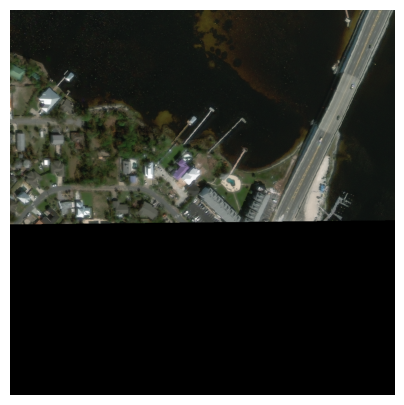

In [5]:
img_test = fnames[34]
PILImage.create(img_test).show()

In [6]:
# fn to get corresponding target image
get_label = lambda x: TRAIN_PATH/'targets'/f'{x.stem}_target.png'

<Axes: >

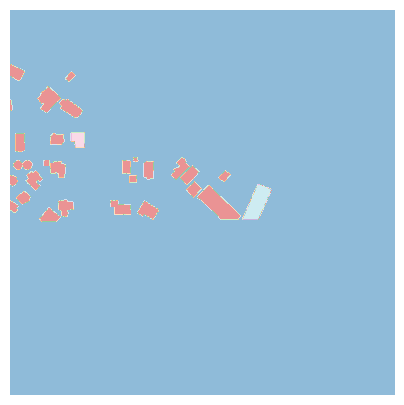

In [7]:
msk = PILMask.create(get_label(img_test))
msk.show()

In [8]:
sz = msk.shape; sz

(1024, 1024)

In [9]:
half = tuple(int(x/2) for x in sz); half

(512, 512)

In [10]:
db = DataBlock(blocks=(ImageBlock, MaskBlock),
               get_items=get_x,
            #    get_x=lambda x: [f for f in get_image_files(x) if "post" in f.name],
               get_y=get_label,
               splitter=RandomSplitter(),
               batch_tfms=[*aug_transforms(size=half)])

# dsets = db.datasets(fnames)

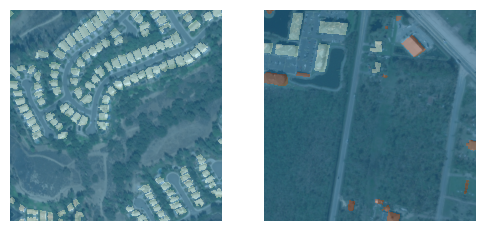

In [11]:
# dls = db.dataloaders(TRAIN_PATH/"images", bs=2)

dls = SegmentationDataLoaders()

# dls.device = DEVICE

dls.show_batch(max_n=4)

In [24]:
opt = ranger
f1score = F1Score()
learn = unet_learner(dls, resnet34, metrics=f1score, self_attention=True, opt_func=opt, n_out=5)
learn.summary()

/home/epound/miniconda3/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/epound/miniconda3/envs/fastai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DynamicUnet (Input shape: 2 x 3 x 512 x 512)
Layer (type)         Output Shape         Param #    Trainable 
                     2 x 64 x 256 x 256  
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     2 x 64 x 128 x 128  
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      

SuggestedLRs(valley=0.0002290867705596611)

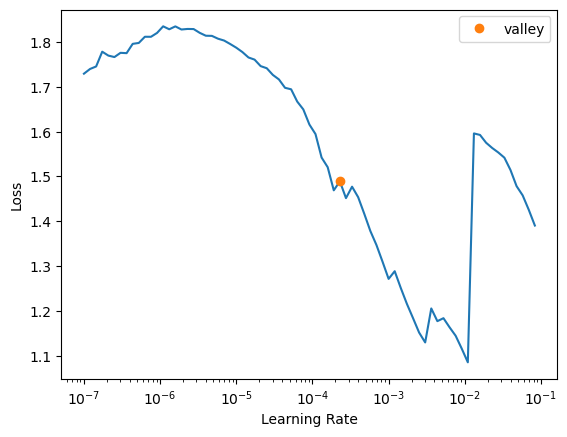

In [25]:
learn.lr_find()

In [26]:
lr = 2e-4

In [28]:
learn.fit_flat_cos(10, slice(lr))

epoch,train_loss,valid_loss,f1_score,time


AssertionError: Exception occured in `Recorder` when calling event `after_batch`:
	==:
5120
524288

In [23]:
len()

2